In [250]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as tt

from tqdm import tqdm_notebook as tqdm

# Example 2.6

In [8]:
u = np.arange(11)
n_black = np.arange(11)
n_white = 10 - n_black

In [67]:
N = 10
nb = 3

In [102]:
prob_black = n_black / 10
print(prob_black)
prob_black = tt.as_tensor_variable(prob_black)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [154]:
with pm.Model() as m:
    
    p = pm.DiscreteUniform('u_prob', lower=0, upper=10)
    prob = pm.Deterministic('prob', (p)/10)
    
    outcome = pm.Binomial('like', n=N, p=prob, observed=nb)
    
    trace = pm.sample(draw=5000, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [u_prob]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:00<00:00, 9181.65draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [155]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
u_prob,3.4640,1.412340,0.091099,1.0,6.0,166.214695,0.999649
prob,0.3464,0.141234,0.009110,0.1,0.6,166.214695,0.999649


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


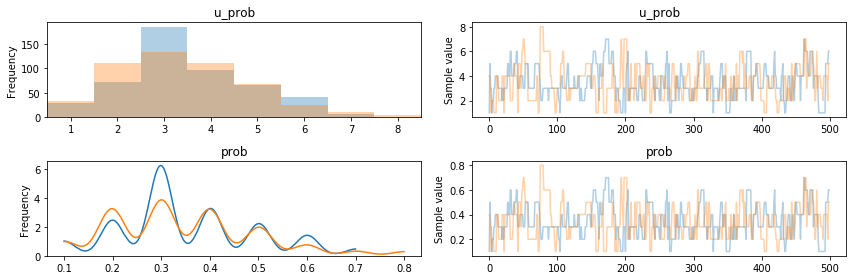

In [156]:
pm.traceplot(trace);

# Exercise 2.35

In [215]:
def do_roll():
    return np.random.randint(1, 7)

## a. Time between one six to the next one

In [337]:
def do_run(n_samps=1000):

    n = 0
    n_rolls = np.empty(n_samps)
    t = 0

    while n < n_samps:
        roll = do_roll()
        t += 1
        if roll == 6:
            n_rolls[n] = t
            n += 1
            
    return n_rolls

In [418]:
f = np.frompyfunc(do_run, 1, 1)
simulations = np.stack(f(np.repeat(1000, 1000)))

In [608]:
simulations

array([[5.000e+00, 9.000e+00, 2.700e+01, ..., 6.006e+03, 6.008e+03,
        6.014e+03],
       [9.000e+00, 1.000e+01, 1.700e+01, ..., 6.059e+03, 6.060e+03,
        6.066e+03],
       [2.000e+00, 1.300e+01, 2.600e+01, ..., 6.088e+03, 6.090e+03,
        6.091e+03],
       ...,
       [4.000e+00, 8.000e+00, 1.500e+01, ..., 5.911e+03, 5.920e+03,
        5.924e+03],
       [5.000e+00, 6.000e+00, 7.000e+00, ..., 5.843e+03, 5.850e+03,
        5.862e+03],
       [2.200e+01, 2.400e+01, 2.600e+01, ..., 5.913e+03, 5.915e+03,
        5.916e+03]])

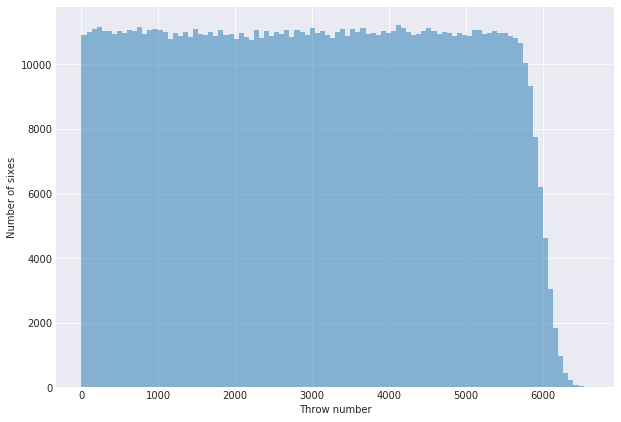

In [649]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 7))
plt.hist(simulations.ravel(), bins=100, alpha = 0.5);
sns.despine(left=True)
plt.xlabel("Throw number")
plt.ylabel("Number of sixes")

plt.savefig("../../../sidravi1.github.io/assets/2018_11_14_hist_sixes.png")

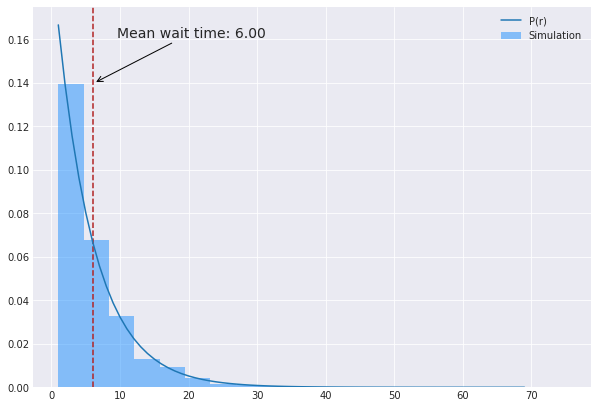

In [730]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 7))

wait_times = simulations[:, 1:] - simulations[:, :-1] 
plt.hist(wait_times.ravel(), bins=20, alpha=0.5, density=True, label="Simulation", color='dodgerblue');
plt.annotate(text="Mean wait time: {:0.2f}".format(wait_times.mean()), xy=(0.11, 0.8), 
             xytext=(0.15, 0.92), fontsize=14, xycoords='axes fraction', arrowprops= {'arrowstyle':"->"})
plt.axvline(x=wait_times.mean(), color='firebrick', ls="--")

P = lambda r: (5/6)**(r-1) * (1/6)
plt.plot(np.arange(1, 70), P(np.arange(1, 70)), label='P(r)')

plt.legend()
plt.savefig("../../../sidravi1.github.io/assets/2018_11_14_pdf_waitimes.png")

## b. Wait times AFTER clock strikes one

Let's say the clock strikes one at Xth second

In [710]:
X = np.random.randint(0, high=simulations.max()//1.1)
X = X - 0.5

In [711]:
def get_time_to_next(sim, X):
    
    after_strike = sim[sim > X]
    if len(after_strike) == 0:
        # there were no throws after the clock struck 1
        # we'll ignore these edge cases.
        return np.nan
    else:
        return after_strike.min() - X
    
to_next = np.apply_along_axis(lambda a: get_time_to_next(a, X), 1, simulations)
np.nanmean(test)

5.708

## c. Wait times BEFORE clock strikes one

In [712]:
def get_time_waited(sim, X):
    
    before_strike = sim[sim < X]
    if len(before_strike) == 0:
        return np.nan
    else:
        return X - before_strike.max()
    
    
test = np.apply_along_axis(lambda a: get_time_waited(a, X), 1, simulations)
np.nanmean(test)

5.259

## d. Wait times BEFORE and AFTER clock strikes one

In [716]:
def get_time_window(sim, X):
    
    before_strike = sim[sim < X]
    after_strike = sim[sim > X]
    
    if (len(after_strike) == 0) or (len(before_strike) == 0):
        return np.nan
    else:
        return after_strike.min() - before_strike.max()
    
window_around_strike = np.apply_along_axis(lambda a: get_time_window(a, X), 1, simulations)
np.nanmean(window_around_strike)

10.967

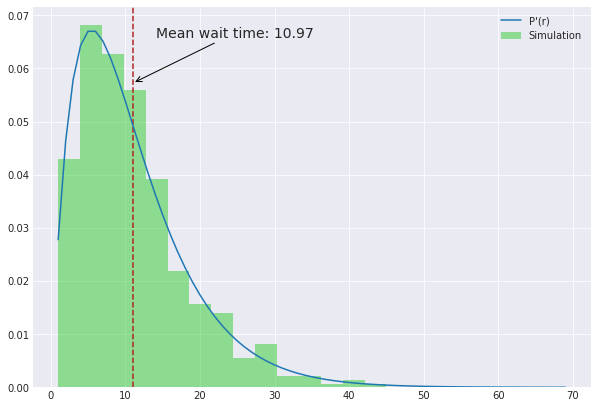

In [729]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 7))

#wait_times = simulations[:, 1:] - simulations[:, :-1] 
plt.hist(window_around_strike.ravel(), bins=15, alpha=0.5, density=True, label="Simulation", color='limegreen');
plt.annotate(text="Mean wait time: {:0.2f}".format(window_around_strike.mean()), xy=(0.18, 0.8), 
             xytext=(0.22, 0.92), fontsize=14, xycoords='axes fraction', arrowprops= {'arrowstyle':"->"})
plt.axvline(x=window_around_strike.mean(), color='firebrick', ls="--")

P = lambda r: r*(5/6)**(r-1) * (1/6)**2
plt.plot(np.arange(1, 70), P(np.arange(1, 70)), label='P\'(r)')

plt.legend()
plt.savefig("../../../sidravi1.github.io/assets/2018_11_14_pdf_waitimes_strike.png")

## e. How do you explain a. vs. d.

When an (unrelated) events happens like the clock striking one, it is more likely to happen in the longer rolls. 

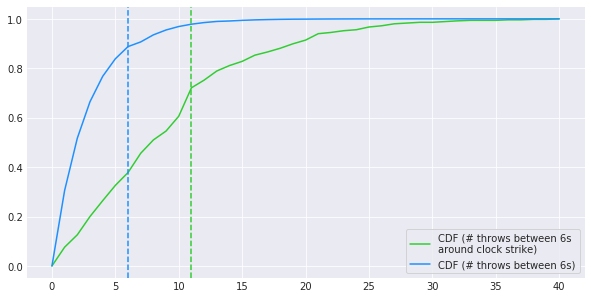

In [748]:
sns.set_style('darkgrid')

pdf_bias = np.histogram(window_around_strike, bins=40)[0]
cdf_bias = np.insert(np.cumsum(pdf_bias), 0, 0)
cdf_bias = cdf_bias / 1000

pdf = np.histogram(wait_times.ravel(), bins=40)[0]
cdf = np.insert(np.cumsum(pdf), 0 , 0)
cdf = cdf / cdf.max()
plt.figure(figsize=(10, 5))
plt.plot(cdf_bias, color='limegreen', label='CDF (# throws between 6s \naround clock strike)')
plt.axvline(window_around_strike.mean(), color='limegreen', ls = "--")
plt.plot(cdf, color='dodgerblue', label='CDF (# throws between 6s)')
plt.axvline(wait_times.mean(), color='dodgerblue', ls = "--")
plt.legend(loc=4, frameon=True)
sns.despine(left=True)
plt.grid(True, axis='both')

plt.savefig("../../../sidravi1.github.io/assets/2018_11_14_cdf_waitimes.png")

In [596]:
np.random.randint(0, simulations.shape[0], size=10)

array([480, 427, 576, 327, 134, 939, 420, 205, 864, 258])

(5.915315315315316, 11.9)

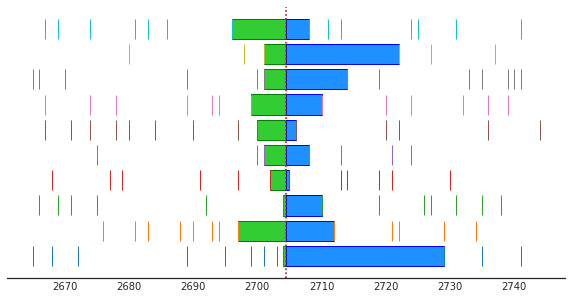

In [745]:
window_size = 40
plt.figure(figsize=(10, 5))
sns.set_style('white')

np.random.seed(32)
mean_all = []
mean_clock_window = []

for i, sample_num in enumerate(np.random.randint(0, simulations.shape[0], size=10)):   
    sim1 = simulations[sample_num, :]
    sim1_window = sim1[(sim1 < (X + window_size)) & (sim1 > (X - window_size))]
    
    plt.plot(sim1_window, [i]* len(sim1_window), "|", ms=20)
    plt.axvline(X, color='firebrick', alpha=0.2, ls =":")
    
    lower = sim1_window[sim1_window < X].max()
    upper = sim1_window[sim1_window > X].min()
    
    plt.barh(i, width = X - lower, left=lower, ec='g', color='limegreen')
    plt.barh(i, width = upper - X, left=X, ec='b', color='dodgerblue')
    
    mean_all.append((sim1[1:] - sim1[:-1]).mean())
    mean_clock_window.append(upper - lower)
    
sns.despine(left=True)
plt.yticks(ticks=[])
plt.grid(False)
plt.savefig("../../../sidravi1.github.io/assets/2018_11_14_window.png")
np.mean(mean_all), np.mean(mean_clock_window)

The reasoning goes as follows:
- The dice is thrown every second
- There are more seconds between longer spans without a 6
- and therefore more likely that the clock strikes between one of the longer spans.

It is analagous to the waiting time paradox that you may be familiar with:
- Passengers come every second (or uniformly)
- There are more passengers waiting during longer spans without a bus
- and therefore more likely that a passenger will be on a bus that was delayed